# Feature Extraction VGG16

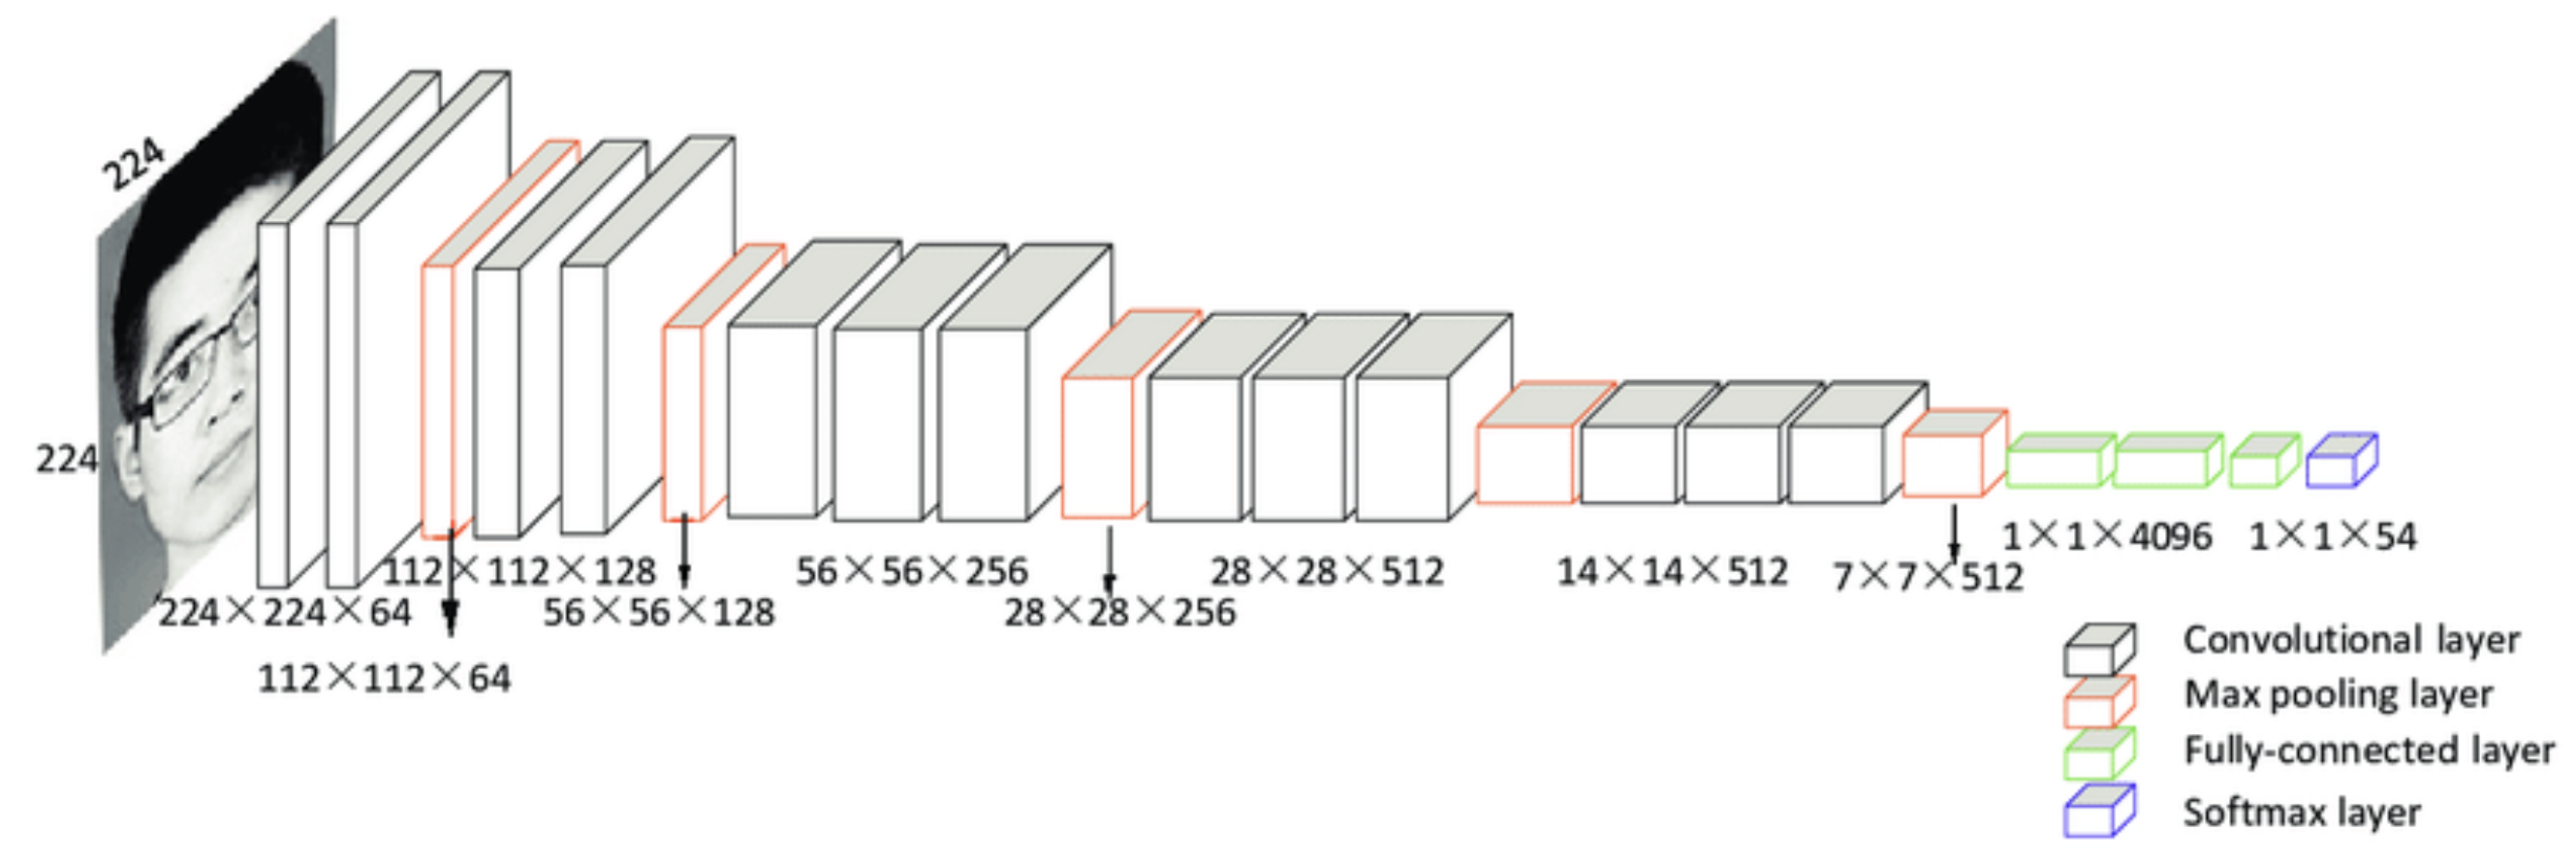

Pei, Zhao & Xu, Hang & Zhang, Yanning & Guo, Min & Yang, Yee-Hong. (2019). Face Recognition via Deep Learning Using Data Augmentation Based on Orthogonal Experiments. Electronics. 8. 1088. 10.3390/electronics8101088. 

## Data Loading

In [4]:
from src.preprocessing import CustomDataGenerator
from src.dataloader import read_train, read_val, read_test
X_train, y_train = read_train()
X_val, y_val = read_val()
X_test, y_test = read_test()

## Network Extraction

Use keras to extract the network from the VGG16 model. The network is then saved to a file for later use.

In [2]:
import keras
from src import config
from keras.applications.vgg16 import preprocess_input
INPUT_SHAPE = (config.IMG_SIZE, config.IMG_SIZE, config.N_CHANNELS)
model = keras.applications.VGG16(weights="imagenet", 
                                 include_top=True)

2023-12-02 17:15:31.601070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 17:15:31.614401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 17:15:31.614520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
model.layers[9].name

'block3_conv3'

In [4]:
extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)

extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
from skimage.transform import resize
import numpy as np
import pandas as pd

X_exp, y_exp = X_train[:3000], y_train[:3000]
# X_exp, y_exp = X_train_sample, y_train_sample
X_exp = [preprocess_input(resize(x, (224, 224), preserve_range=True)) for x in X_exp]
df_ext = pd.DataFrame(extractor.predict(np.array(X_exp)))
df_ext.shape

2023-11-27 18:58:44.962702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-27 18:58:45.034325: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-11-27 18:58:45.034338: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-11-27 18:58:45.034372: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 4/94 [>.............................] - ETA: 5s

2023-11-27 18:58:45.921453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


94/94 [==============================] - 9s 89ms/step


(3000, 4096)

In [9]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# sns.set(style='white', context='poster', rc={'figure.figsize':(10,5)})
reducer = umap.UMAP()
sc = StandardScaler()
embedding = reducer.fit_transform(sc.fit_transform(df_ext))
embedding.shape

/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(3000, 2)

Text(0.5, 1.0, 'UMAP projection of VGG16 4096 features')

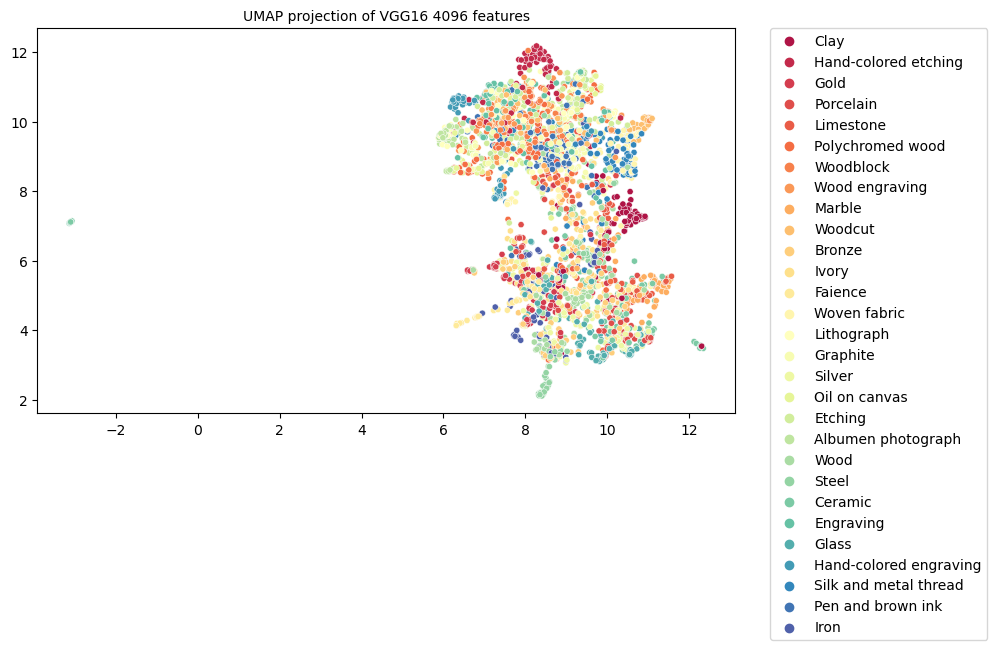

In [10]:
# REset the default matplotlib color cycle
plt.figure(figsize=(9,5))
y_labels = [config.LABELS[y] for y in y_exp]

sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_labels, marker='o', s=20,
                 palette='Spectral', legend='full')
# plt.legend([])
# place legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('UMAP projection of VGG16 4096 features', fontsize=10)

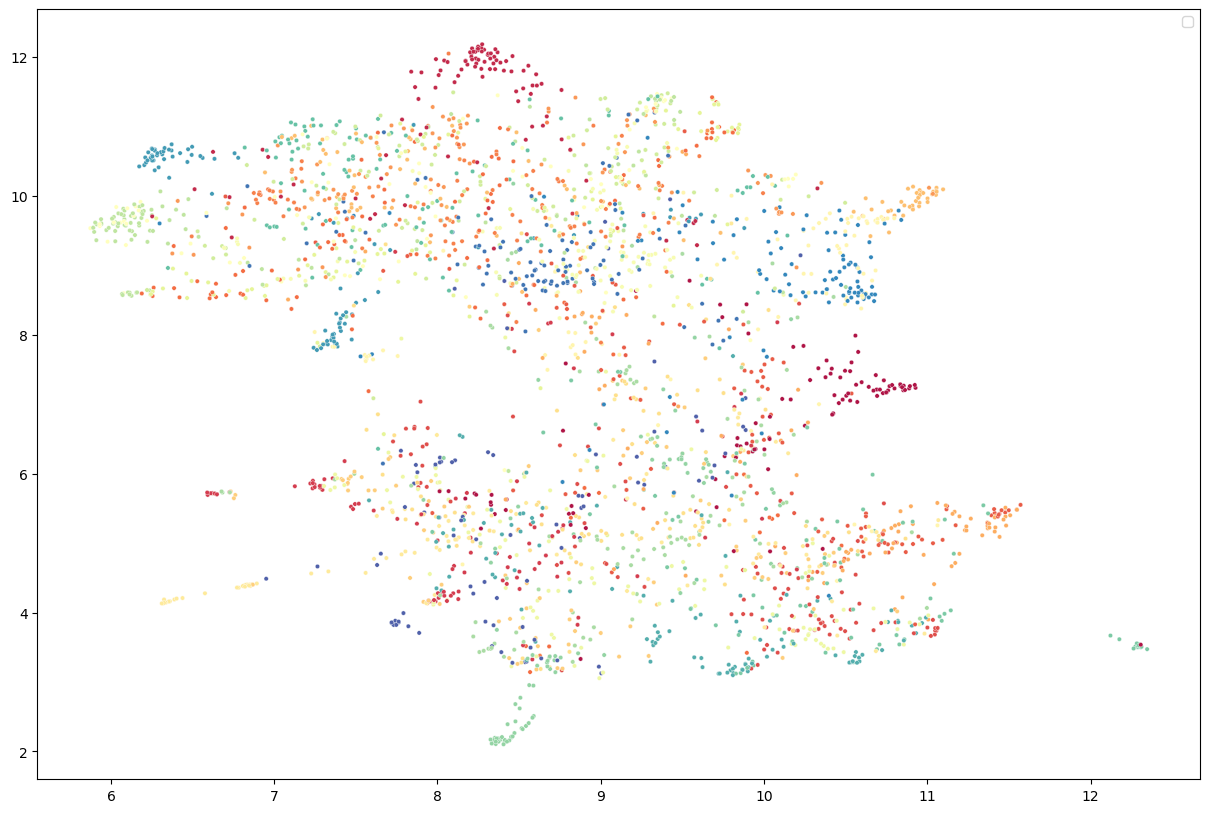

In [11]:
# REset the default matplotlib color cycle
plt.figure(figsize=(15,10))
y_labels = [config.LABELS[y] for y in y_exp[embedding[:, 0]>4]]
embedding_WO = embedding[embedding[:, 0]>4]
sns.scatterplot(x=embedding_WO[:, 0], y=embedding_WO[:, 1], hue=y_labels, marker='o', s=10,
                 palette='Spectral', legend='full')
plt.legend([])

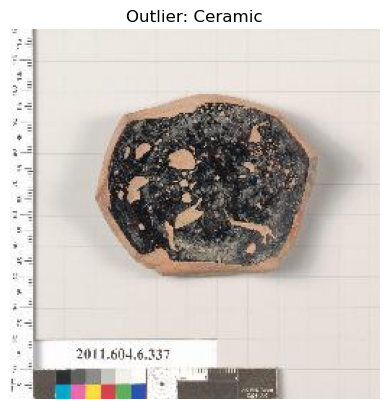

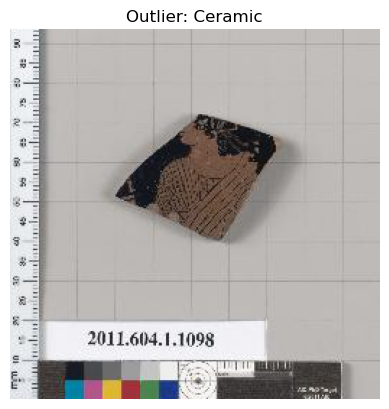

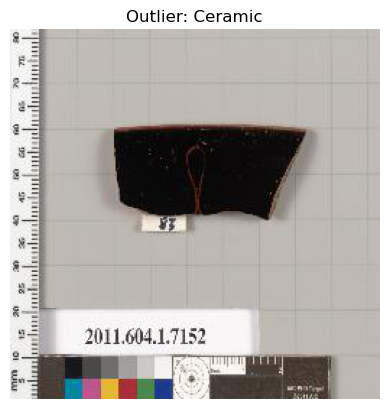

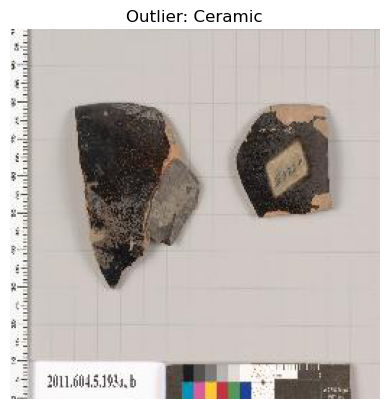

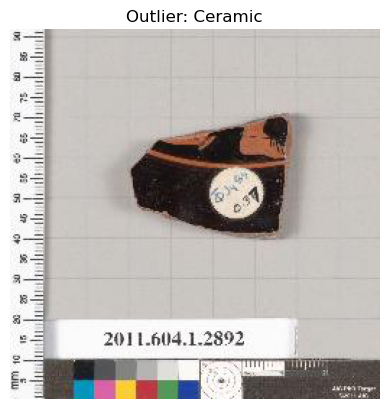

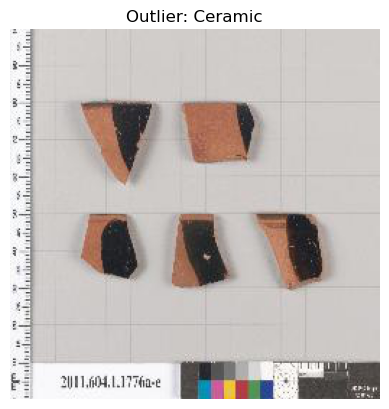

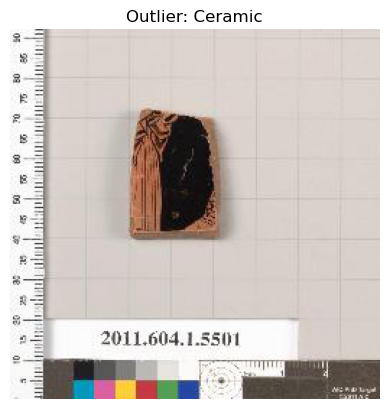

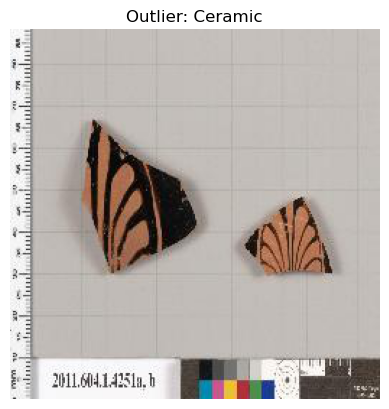

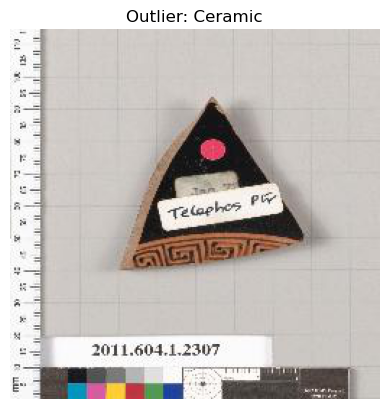

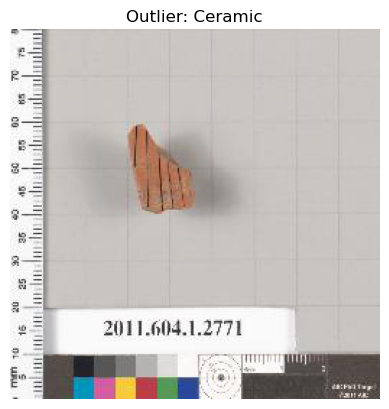

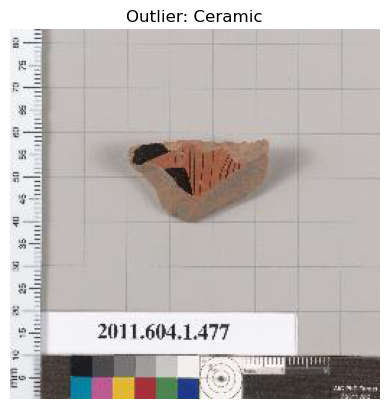

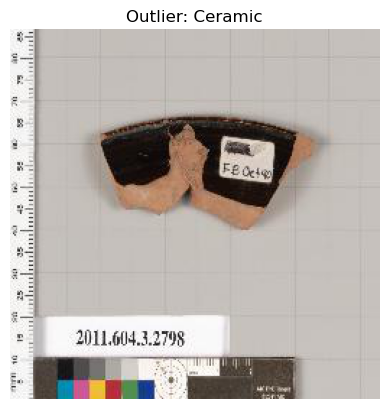

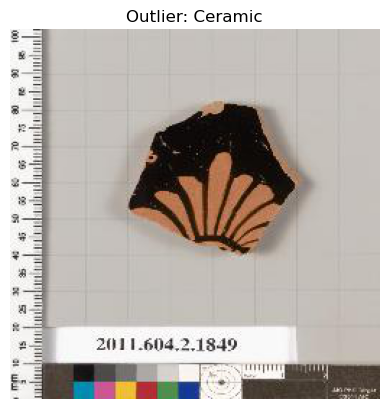

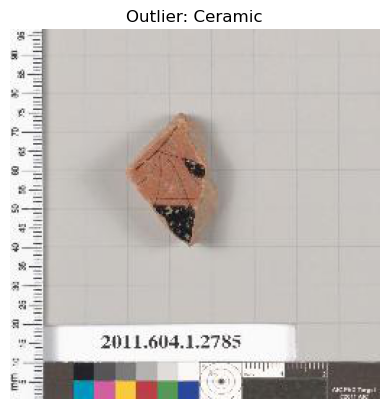

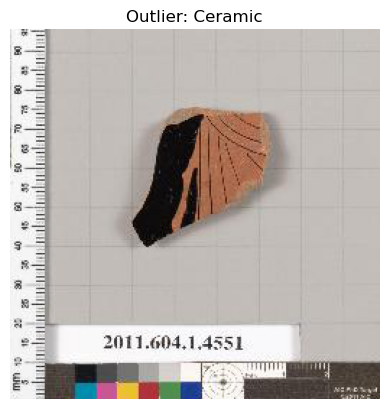

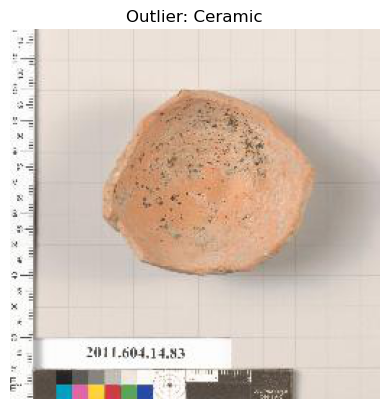

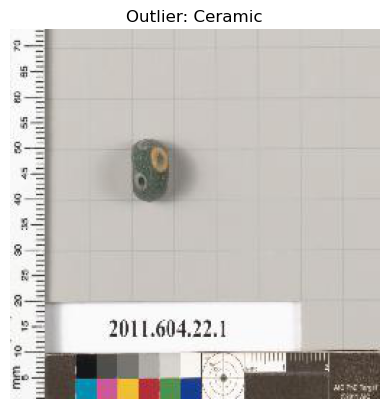

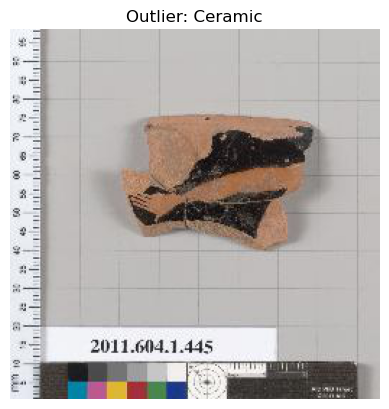

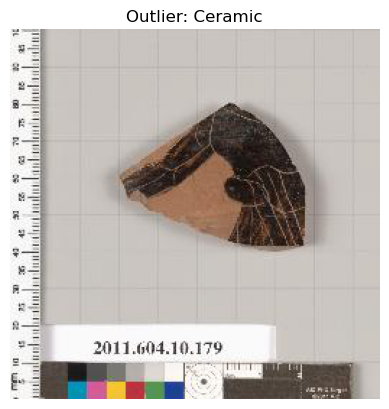

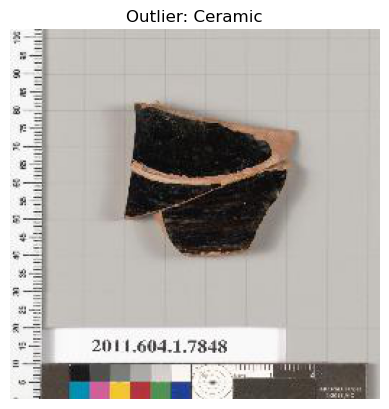

In [12]:
idx_outliers = np.where(embedding[:, 0] <2)[0]
X_outliers = X_train[idx_outliers, :]

for x in X_outliers:
    plt.imshow(x)
    plt.title("Outlier: {}".format(config.LABELS[y_exp[idx_outliers][0]]))
    plt.axis('off')
    plt.show()

In [13]:
reducer = umap.UMAP()
sc = StandardScaler()
df_ext_wo = df_ext[embedding[:, 0]>4]
embedding_wo = reducer.fit_transform(sc.fit_transform(df_ext_wo))
embedding_wo.shape

(2980, 2)

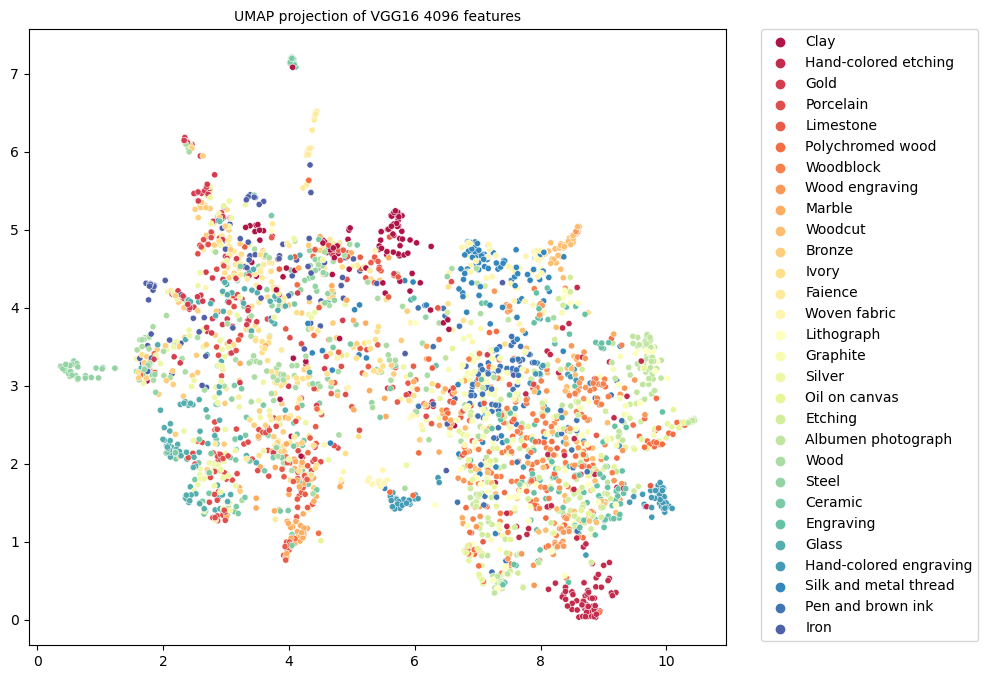

In [43]:
# REset the default matplotlib color cycle
plt.figure(figsize=(9,8))
y_labels = [config.LABELS[y] for y in y_exp[embedding[:, 0]>4]]

sns.scatterplot(x=embedding_wo[:, 0], y=embedding_wo[:, 1], hue=y_labels, marker='o', s=20,
                 palette='Spectral', legend='full')
# plt.legend([])
# place legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('UMAP projection of VGG16 4096 features', fontsize=10)

# now using plotly
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=embedding_wo[:, 0], y=embedding_wo[:, 1], color=y_labels)
fig.show()

In [45]:
reducer = umap.UMAP(n_components=3)
sc = StandardScaler()
df_ext_wo = df_ext[embedding[:, 0]>4]
embedding_wo = reducer.fit_transform(sc.fit_transform(df_ext_wo))
embedding_wo.shape

# Plot 3D t-SNE USING PLOTLY
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.io as pio

pio.templates.default = "plotly_white"
fig = px.scatter_3d(embedding_wo, x=0, y=1, z=2, color=y_labels, opacity=1.)

fig.update_layout(
    title="3D UMAP projection of VGG16 features",
    scene = dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z'
    )
)

# REduce marker size
for i in range(len(fig.data)):
    fig.data[i].marker.size = 2

fig.show()

In [ ]:
idx_outliers = np.where((embedding[:, 0] <2)&())[0]
X_outliers = X_train[idx_outliers, :]

for x in X_outliers:
    plt.imshow(x)
    plt.title("Outlier: {}".format(config.LABELS[y_exp[idx_outliers][0]]))
    plt.axis('off')
    plt.show()

Text(0.5, 1.0, 'T-SNE projection of VGG16 4096 features')

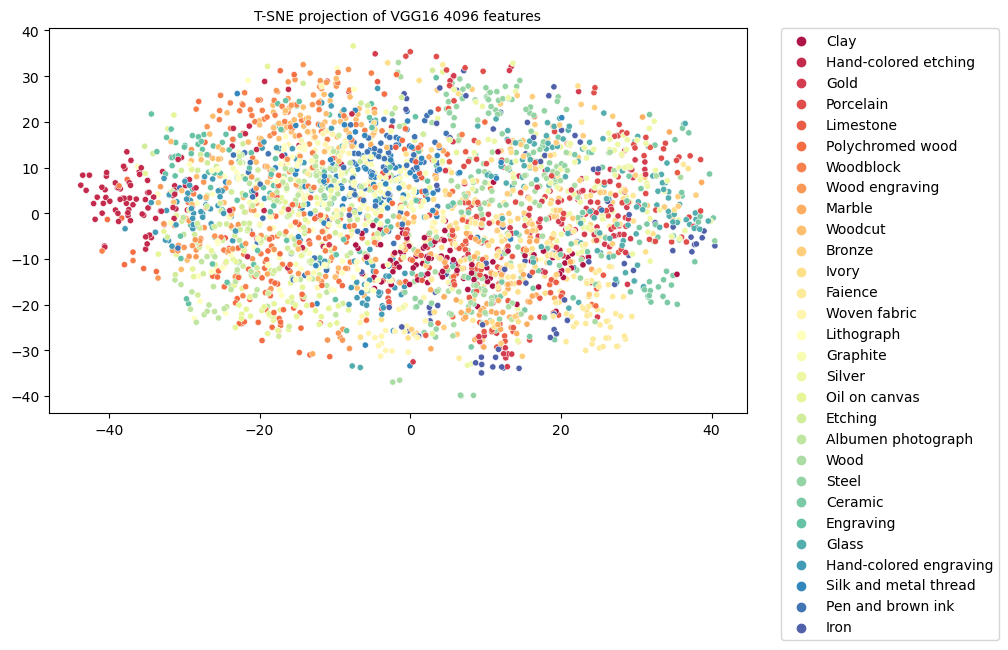

In [40]:
# Use t-sne to visualize the data
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, random_state=42)
sc = StandardScaler()
X_embedded = tsne.fit_transform(sc.fit_transform(df_ext_wo))
X_embedded.shape

# REset the default matplotlib color cycle
plt.figure(figsize=(9,5))
y_labels = [config.LABELS[y] for y in y_exp[embedding[:, 0]>4]]

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_labels, marker='o', s=20,
                 palette='Spectral', legend='full')
# plt.legend([])
# place legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('T-SNE projection of VGG16 4096 features', fontsize=10)

In [16]:
%reload_ext plotly.express

In [39]:
# Plot 3D t-SNE USING PLOTLY
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.io as pio

pio.templates.default = "plotly_white"
fig = px.scatter_3d(X_embedded, x=0, y=1, z=2, color=y_labels, opacity=1.)

fig.update_layout(
    title="3D t-SNE projection of VGG16 features",
    scene = dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z'
    )
)

# REduce marker size
for i in range(len(fig.data)):
    fig.data[i].marker.size = 2

fig.show()

In [28]:
# use pca to reduce the dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
sc = StandardScaler()
X_embedded = pca.fit_transform(sc.fit_transform(df_ext_wo))
X_embedded.shape

pio.templates.default = "plotly_white"
fig = px.scatter_3d(X_embedded, x=0, y=1, z=2, color=y_labels, opacity=1.)

fig.update_layout(
    title="3D PCA projection of VGG16 features",
    scene = dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z'
    )
)

# REduce marker size
for i in range(len(fig.data)):
    fig.data[i].marker.size = 2

fig.show()

Text(0.5, 1.0, '0.9 Explained variance 955 components')

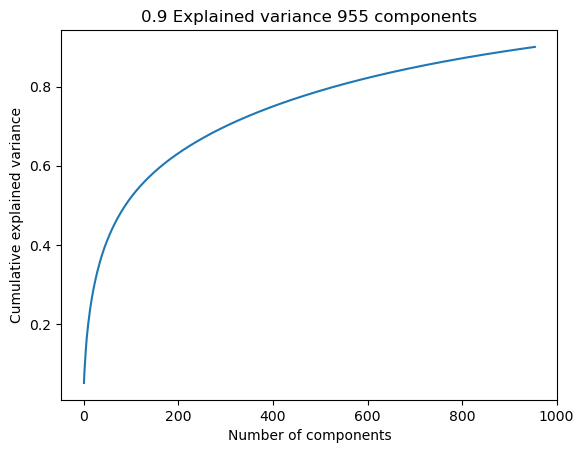

In [36]:
# plot explained variance for 100 components
pct_explained = .9
pca = PCA(n_components=pct_explained)
sc = StandardScaler()
pca.fit_transform(sc.fit_transform(df_ext_wo))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.title(f"{pct_explained} Explained variance {pca.n_components_} components")

In [20]:
# X_ceramic = X_train[np.where(y_train == 2)[0], :]
# for x in X_ceramic:
#     plt.imshow(x)
#     plt.title("Ceramic")
#     plt.show()

## Add a classifier on top of the convolutional base

In [26]:
def add_classifier(model, ls_layers,
                   n_classes=config.N_CLASSES,
                   scale_orig=1/255.0):
    
    # Freeze the layers which you don't want to train. Here I am freezing the first 10 layers.
    model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=(config.IMG_SIZE, config.IMG_SIZE, config.N_CHANNELS))

    scale_layer = keras.layers.Rescaling(scale=scale_orig)
    x = scale_layer(inputs)

    model_layers = model.layers[1:]

    for layer in model_layers + ls_layers:
        x = layer(x)

    outputs = keras.layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

ls_classifiers = [keras.layers.Flatten(),
                  keras.layers.Dense(1024, activation='relu'),
                  keras.layers.Dropout(0.3),
                  keras.layers.Dense(512, activation='relu'),]

model_clas = add_classifier(model, ls_classifiers)
model_clas.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584

## Train Model

In [27]:
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 10

train_generator = CustomDataGenerator(X_train, y_train, BATCH_SIZE)

In [28]:
model_clas = add_classifier(model, ls_classifiers)

# compile the model 
model_clas.compile(loss = "sparse_categorical_crossentropy", 
                    optimizer = keras.optimizers.legacy.Adam(lr=LEARNING_RATE), 
                    metrics=["accuracy"])

In [29]:
history = model_clas.fit(train_generator,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_val, y_val),
                            verbose=1)

Epoch 1/10
635/635 [==============================] - 76s 119ms/step - loss: 2.1324 - accuracy: 0.3725 - val_loss: 1.4923 - val_accuracy: 0.5262
Epoch 2/10
635/635 [==============================] - 76s 119ms/step - loss: 1.5492 - accuracy: 0.5072 - val_loss: 1.3392 - val_accuracy: 0.5800
Epoch 3/10
635/635 [==============================] - 76s 119ms/step - loss: 1.3105 - accuracy: 0.5681 - val_loss: 1.3035 - val_accuracy: 0.5614
Epoch 4/10
635/635 [==============================] - 76s 119ms/step - loss: 1.1903 - accuracy: 0.6089 - val_loss: 1.2067 - val_accuracy: 0.6014
Epoch 5/10
635/635 [==============================] - 76s 120ms/step - loss: 1.0473 - accuracy: 0.6536 - val_loss: 1.1321 - val_accuracy: 0.6324
Epoch 6/10
635/635 [==============================] - 76s 119ms/step - loss: 0.9632 - accuracy: 0.6780 - val_loss: 1.1344 - val_accuracy: 0.6303
Epoch 7/10
635/635 [==============================] - 75s 119ms/step - loss: 0.8988 - accuracy: 0.6989 - val_loss: 1.1150 - val_ac

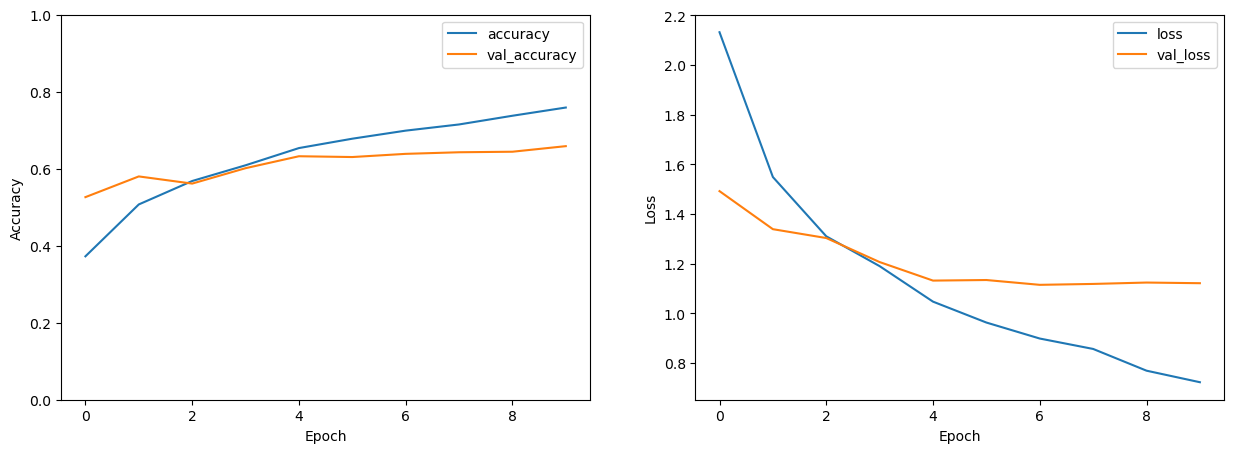

In [30]:
%reload_ext src.results
from src.results import plot_history
plot_history(model_clas);